In [1]:
!git clone https://github.com/TranTheHung2312332/age-gender-prediction

Cloning into 'age-gender-prediction'...
remote: Enumerating objects: 23346, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 23346 (delta 0), reused 5 (delta 0), pack-reused 23339 (from 1)
Receiving objects: 100% (23346/23346), 110.55 MiB | 41.71 MiB/s, done.
Updating files: 100% (23719/23719), done.


In [16]:
!cp age-gender-prediction/labeled -r .

In [2]:
from torchvision import transforms
import torch

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class RandomCutout:
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.shape[1], img.shape[2]
        mask = torch.ones((h, w), dtype=torch.float32)

        for _ in range(self.n_holes):
            y = torch.randint(h, (1,)).item()
            x = torch.randint(w, (1,)).item()

            y1 = max(0, y - self.length // 2)
            y2 = min(h, y + self.length // 2)
            x1 = max(0, x - self.length // 2)
            x2 = min(w, x + self.length // 2)

            mask[y1:y2, x1:x2] = 0.

        mask = mask.expand_as(img)
        img = img * mask

        return img

def get_transforms(img_size=224):
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        RandomCutout(n_holes=1, length=16),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

    eval_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

    return train_transform, eval_transform, eval_transform

In [3]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image


class FaceDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, validate_files=True):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        required = {'name', 'age', 'gender'}
        missing = required - set(self.df.columns)
        if missing:
            raise ValueError(f"Missing columns in {csv_file}: {missing}")
        if validate_files:
            self._validate_images()

    def _validate_images(self):
        valid_mask = self.df['name'].apply(
            lambda x: os.path.exists(os.path.join(self.img_dir, x))
        )
        n_missing = (~valid_mask).sum()
        if n_missing > 0:
            self.df = self.df[valid_mask].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['name'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        sample = {
            'age':    torch.tensor(int(row['age']), dtype=torch.float32),
            'gender': torch.tensor(int(row['gender']), dtype=torch.long)
        }
        return image, sample

    def get_class_distribution(self, column='gender'):
        return self.df[column].value_counts().to_dict()

    def get_stats(self):
        stats = {
            'total_samples': len(self.df),
            'age_mean': self.df['age'].mean(),
            'age_std': self.df['age'].std(),
            'age_min': self.df['age'].min(),
            'age_max': self.df['age'].max(),
            'gender_distribution': self.df['gender'].value_counts().to_dict()
        }
        return stats

In [4]:
from torch.utils.data import DataLoader, WeightedRandomSampler, default_collate

def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return None
    return default_collate(batch)

def build_loaders(
    train_csv="labeled/train/label.csv", train_img="labeled/train/img",
    val_csv="labeled/valid/label.csv",     val_img="labeled/valid/img",
    test_csv="labeled/test/label.csv",   test_img="labeled/test/img",
    img_size=224, batch_size=32, num_workers=0, pin_memory=False,
    use_weighted_sampler=False, validate_files=False, drop_last=False
):
    train_t, val_t, test_t = get_transforms(img_size)

    train_ds = FaceDataset(train_csv, train_img, transform=train_t, validate_files=validate_files)
    val_ds   = FaceDataset(val_csv,   val_img,   transform=val_t,   validate_files=validate_files)
    test_ds  = FaceDataset(test_csv,  test_img,  transform=test_t,  validate_files=validate_files)

    sampler = None
    if use_weighted_sampler:
        g = train_ds.df["gender"].astype(int)
        counts = g.value_counts().to_dict()
        weights = {c: 1.0 / counts[c] for c in counts}
        sample_weights = g.map(weights).values
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_ld = DataLoader(
        train_ds, batch_size=batch_size,
        shuffle=(sampler is None), sampler=sampler,
        num_workers=num_workers, pin_memory=pin_memory,
        drop_last=drop_last, collate_fn=safe_collate
    )
    val_ld = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory,
        drop_last=False, collate_fn=safe_collate
    )
    test_ld = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory,
        drop_last=False, collate_fn=safe_collate
    )
    return train_ld, val_ld, test_ld


In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights

class AgeGenderModel(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        weights = ResNet50_Weights.DEFAULT if pretrained else None
        backbone = models.resnet50(weights=weights)

        self.feature_dim = backbone.fc.in_features

        self.backbone = nn.Sequential(*list(backbone.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d(1)

        # Age head (regression)
        self.age_head = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 1)
        )

        # Gender head (binary classification)
        self.gender_head = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        f = self.backbone(x)
        f = self.pool(f).view(x.size(0), -1)

        age_pred = self.age_head(f).squeeze(1)
        gender_logit = self.gender_head(f).squeeze(1)

        return age_pred, gender_logit


In [6]:
import torch
import torch.nn as nn

class MultiTaskLoss:
    def __init__(self, alpha=1.0, beta=0.2):
        self.alpha = alpha
        self.beta = beta
        self.mae = nn.L1Loss()
        self.bce = nn.BCEWithLogitsLoss()

    def __call__(self, age_pred, age_target, gender_logit, gender_target):
        loss_age = self.mae(age_pred, age_target)
        loss_gender = self.bce(gender_logit, gender_target)

        loss = self.alpha * loss_age + self.beta * loss_gender
        return loss, loss_age, loss_gender


In [7]:
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score

class Trainer:
    def __init__(
        self,
        model,
        criterion,
        optimizer,
        scheduler=None,
        device="cuda",
        early_stop_patience=10,
        verbose=True
    ):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.early_stop_patience = early_stop_patience
        self.verbose = verbose

        self.best_val_loss = float("inf")
        self.no_improve_epochs = 0

        self.history = {
            "train_age_loss": [], "train_gender_loss": [], "train_gender_acc": [],
            "val_age_loss": [], "val_gender_loss": [], "val_gender_acc": []
        }

    def run_epoch(self, loader, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

        total_loss = 0
        age_loss_sum = 0
        gender_loss_sum = 0
        gender_acc_sum = 0
        n_batches = 0

        loop = tqdm(loader, desc="Train" if train else "Valid", leave=False)

        for imgs, targets in loop:
            if imgs is None:
                continue

            imgs = imgs.to(self.device)
            age_gt = targets["age"].to(self.device)
            gender_gt = targets["gender"].float().to(self.device)

            if train:
                self.optimizer.zero_grad()

            with torch.set_grad_enabled(train):
                age_pred, gender_logit = self.model(imgs)
                loss, l_age, l_gender = self.criterion(age_pred, age_gt, gender_logit, gender_gt)

                if train:
                    loss.backward()
                    self.optimizer.step()

            # compute gender accuracy
            probs = torch.sigmoid(gender_logit)
            preds = (probs > 0.5).float()
            acc = (preds == gender_gt).float().mean().item()

            total_loss += loss.item()
            age_loss_sum += l_age.item()
            gender_loss_sum += l_gender.item()
            gender_acc_sum += acc
            n_batches += 1

        return (
            total_loss / n_batches,
            age_loss_sum / n_batches,
            gender_loss_sum / n_batches,
            gender_acc_sum / n_batches
        )

    def fit(self, train_loader, val_loader, n_epochs=30):
        print("Training started...")

        for epoch in range(1, n_epochs + 1):
            print(f"\n===== Epoch {epoch}/{n_epochs} =====")

            train_loss, train_age, train_gender, train_acc = self.run_epoch(train_loader, train=True)
            val_loss, val_age, val_gender, val_acc = self.run_epoch(val_loader, train=False)

            # Save history
            self.history["train_age_loss"].append(train_age)
            self.history["train_gender_loss"].append(train_gender)
            self.history["train_gender_acc"].append(train_acc)

            self.history["val_age_loss"].append(val_age)
            self.history["val_gender_loss"].append(val_gender)
            self.history["val_gender_acc"].append(val_acc)

            # Print metrics including Gender Accuracy
            print(
                f"Train: loss={train_loss:.4f}, age={train_age:.4f}, gender_loss={train_gender:.4f}, gender_acc={train_acc:.4f}\n"
                f"Valid: loss={val_loss:.4f}, age={val_age:.4f}, gender_loss={val_gender:.4f}, gender_acc={val_acc:.4f}"
            )

            # Scheduler step
            if self.scheduler:
                self.scheduler.step()

            # Early stopping
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.no_improve_epochs = 0
                torch.save(self.model.state_dict(), "best_model.pth")
                if self.verbose:
                    print("→ Saved new best model.")
            else:
                self.no_improve_epochs += 1
                if self.verbose:
                    print(f"No improvement for {self.no_improve_epochs} epochs.")

            if self.no_improve_epochs >= self.early_stop_patience:
                print("Early stopping triggered.")
                break

        print("Training finished.")


In [8]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def evaluate_metrics(age_pred, age_gt, gender_pred, gender_gt):
    # Age regression metrics
    mae = torch.abs(age_pred - age_gt).mean().item()
    rmse = torch.sqrt(torch.mean((age_pred - age_gt) ** 2)).item()
    mse = torch.mean((age_pred - age_gt) ** 2).item()

    # Gender classification metrics
    gender_pred_class = (torch.sigmoid(gender_pred) > 0.5).long().cpu()
    gender_gt_cpu = gender_gt.long().cpu()

    acc = accuracy_score(gender_gt_cpu, gender_pred_class)
    f1 = f1_score(gender_gt_cpu, gender_pred_class)
    cm = confusion_matrix(gender_gt_cpu, gender_pred_class)

    return mae, rmse, mse, acc, f1, cm


In [9]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

GRID_ALPHA = [0.5, 1.0, 2.0]
GRID_BETA  = [0.05, 0.1, 0.2]

CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [11]:
def train_one_model(alpha, beta):
    print(f"\n====== TRAIN α={alpha} β={beta} ======")

    train_ld, val_ld, test_ld = build_loaders(
        batch_size=32,
        img_size=224,
        num_workers=4,
        use_weighted_sampler=True,
        drop_last=True
    )

    model = AgeGenderModel(pretrained=True)

    criterion = MultiTaskLoss(alpha=alpha, beta=beta)
    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=10)

    trainer = Trainer(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        early_stop_patience=5,
        device=DEVICE
    )

    trainer.fit(train_ld, val_ld, n_epochs=25)

    return trainer, train_ld, val_ld, test_ld, trainer.best_val_loss

In [12]:
def hyperparameter_search():
    results = {}
    best_pair = None
    best_loss = float("inf")
    best_trainer = None
    best_loaders = None

    for alpha in GRID_ALPHA:
        for beta in GRID_BETA:

            trainer, tr, va, te, val_loss = train_one_model(alpha, beta)
            results[(alpha, beta)] = val_loss

            if val_loss < best_loss:
                best_loss = val_loss
                best_pair = (alpha, beta)
                best_trainer = trainer
                best_loaders = (tr, va, te)

                # Save best checkpoint
                torch.save(
                    best_trainer.model.state_dict(),
                    f"{CHECKPOINT_DIR}/best_model.pth"
                )

    print("\n=== GRID SEARCH RESULTS ===")
    for k, v in results.items():
        print(f"α={k[0]}, β={k[1]} -> val_loss={v:.4f}")

    print(f"\n>>> Best α, β = {best_pair} with val_loss={best_loss:.4f}")

    return best_pair, best_trainer, best_loaders

In [30]:
import matplotlib.pyplot as plt

def plot_curves(trainer):
    hist = trainer.history

    # --- Age Loss ---
    plt.figure(figsize=(8,5))
    plt.plot(hist["train_age_loss"], label="Train Age Loss")
    plt.plot(hist["val_age_loss"],   label="Val Age Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Age Loss Curve")
    plt.legend()
    plt.savefig("age_loss_curve.png")

    # --- Gender Loss ---
    plt.figure(figsize=(8,5))
    plt.plot(hist["train_gender_loss"], label="Train Gender Loss")
    plt.plot(hist["val_gender_loss"],   label="Val Gender Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Gender Loss Curve")
    plt.legend()
    plt.savefig("gender_loss_curve.png")

    # --- Total Loss ---
    # total_loss = age_loss + gender_loss
    train_total = [a+b for a,b in zip(hist["train_age_loss"], hist["train_gender_loss"])]
    val_total   = [a+b for a,b in zip(hist["val_age_loss"],   hist["val_gender_loss"])]

    plt.figure(figsize=(8,5))
    plt.plot(train_total, label="Train Loss")
    plt.plot(val_total,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.savefig("total_loss_curve.png")

    print("Saved: age_loss_curve.png, gender_loss_curve.png, total_loss_curve.png")


In [19]:
def evaluate_best_model(model, test_loader):
    model.eval()
    all_age_pred = []
    all_age_gt   = []
    all_gender_pred = []
    all_gender_gt   = []

    with torch.no_grad():
        for imgs, targets in test_loader:
            imgs = imgs.to(DEVICE)
            age_gt = targets["age"].to(DEVICE)
            gender_gt = targets["gender"].float().to(DEVICE)

            age_pred, gender_pred = model(imgs)

            all_age_pred.append(age_pred)
            all_age_gt.append(age_gt)
            all_gender_pred.append(gender_pred)
            all_gender_gt.append(gender_gt)

    all_age_pred = torch.cat(all_age_pred)
    all_age_gt   = torch.cat(all_age_gt)
    all_gender_pred = torch.cat(all_gender_pred)
    all_gender_gt   = torch.cat(all_gender_gt)

    mae, rmse, mse, acc, f1, cm = evaluate_metrics(
        all_age_pred, all_age_gt,
        all_gender_pred, all_gender_gt
    )

    print("\n===== TEST METRICS =====")
    print(f"MAE  = {mae:.3f}")
    print(f"RMSE = {rmse:.3f}")
    print(f"MSE  = {mse:.3f}")
    print(f"Gender Acc = {acc:.3f}")
    print(f"Gender F1  = {f1:.3f}")
    print("Confusion Matrix:\n", cm)


====== TRAIN α=1.0 β=0.2 ======


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 123MB/s]


Training started...

===== Epoch 1/25 =====


Train: loss=9.9144, age=9.8019, gender_loss=0.5628, gender_acc=0.7093
Valid: loss=6.6516, age=6.5585, gender_loss=0.4659, gender_acc=0.7824
→ Saved new best model.

===== Epoch 2/25 =====


Train: loss=6.6216, age=6.5356, gender_loss=0.4297, gender_acc=0.8009
Valid: loss=6.3086, age=6.2399, gender_loss=0.3434, gender_acc=0.8479
→ Saved new best model.

===== Epoch 3/25 =====


Train: loss=5.9883, age=5.9180, gender_loss=0.3516, gender_acc=0.8379
Valid: loss=5.9043, age=5.8382, gender_loss=0.3304, gender_acc=0.8496
→ Saved new best model.

===== Epoch 4/25 =====


Train: loss=5.5471, age=5.4848, gender_loss=0.3112, gender_acc=0.8587
Valid: loss=5.4329, age=5.3780, gender_loss=0.2745, gender_acc=0.8775
→ Saved new best model.

===== Epoch 5/25 =====


Train: loss=5.0775, age=5.0207, gender_loss=0.2841, gender_acc=0.8713
Valid: loss=5.3497, age=5.2967, gender_loss=0.2653, gender_acc=0.8850
→ Saved new best model.

===== Epoch 6/25 =====


Train: loss=4.7787, age=4.7260, gender_loss=0.2637, gender_acc=0.8853
Valid: loss=5.1952, age=5.1443, gender_loss=0.2548, gender_acc=0.8887
→ Saved new best model.

===== Epoch 7/25 =====


Train: loss=4.4611, age=4.4103, gender_loss=0.2541, gender_acc=0.8857
Valid: loss=5.0666, age=5.0181, gender_loss=0.2424, gender_acc=0.8951
→ Saved new best model.

===== Epoch 8/25 =====


Train: loss=4.2046, age=4.1542, gender_loss=0.2518, gender_acc=0.8891
Valid: loss=5.0481, age=4.9995, gender_loss=0.2428, gender_acc=0.8895
→ Saved new best model.

===== Epoch 9/25 =====


Train: loss=4.0261, age=3.9778, gender_loss=0.2417, gender_acc=0.8920
Valid: loss=4.9715, age=4.9241, gender_loss=0.2371, gender_acc=0.8987
→ Saved new best model.

===== Epoch 10/25 =====


Train: loss=3.9127, age=3.8652, gender_loss=0.2377, gender_acc=0.8979
Valid: loss=4.9433, age=4.8972, gender_loss=0.2302, gender_acc=0.9018
→ Saved new best model.

===== Epoch 11/25 =====


Train: loss=3.9101, age=3.8637, gender_loss=0.2323, gender_acc=0.8948
Valid: loss=4.9329, age=4.8861, gender_loss=0.2338, gender_acc=0.8982
→ Saved new best model.

===== Epoch 12/25 =====


Train: loss=3.8854, age=3.8381, gender_loss=0.2368, gender_acc=0.8924
Valid: loss=4.9264, age=4.8794, gender_loss=0.2349, gender_acc=0.8968
→ Saved new best model.

===== Epoch 13/25 =====


Train: loss=3.8523, age=3.8044, gender_loss=0.2392, gender_acc=0.8965
Valid: loss=4.9903, age=4.9437, gender_loss=0.2330, gender_acc=0.8976
No improvement for 1 epochs.

===== Epoch 14/25 =====


Train: loss=3.8382, age=3.7890, gender_loss=0.2462, gender_acc=0.8909
Valid: loss=5.0361, age=4.9901, gender_loss=0.2299, gender_acc=0.8990
No improvement for 2 epochs.

===== Epoch 15/25 =====


Train: loss=3.9038, age=3.8566, gender_loss=0.2359, gender_acc=0.9004
Valid: loss=5.1327, age=5.0867, gender_loss=0.2303, gender_acc=0.8993
No improvement for 3 epochs.

===== Epoch 16/25 =====


Train: loss=3.9532, age=3.9044, gender_loss=0.2443, gender_acc=0.8960
Valid: loss=5.0814, age=5.0346, gender_loss=0.2336, gender_acc=0.8948
No improvement for 4 epochs.

===== Epoch 17/25 =====


Train: loss=4.0859, age=4.0389, gender_loss=0.2346, gender_acc=0.8979
Valid: loss=5.5675, age=5.5208, gender_loss=0.2335, gender_acc=0.8982
No improvement for 5 epochs.
Early stopping triggered.
Training finished.

=== GRID SEARCH RESULTS ===
α=1.0, β=0.2 -> val_loss=4.9264

>>> Best α, β = (1.0, 0.2) with val_loss=4.9264
Saved: age_loss_curve.png, gender_loss_curve.png

Loading best model...

===== TEST METRICS =====
MAE  = 5.496
RMSE = 7.641
MSE  = 58.391
Gender Acc = 0.905
Gender F1  = 0.901
Confusion Matrix:
 [[1671  190]
 [ 149 1547]]


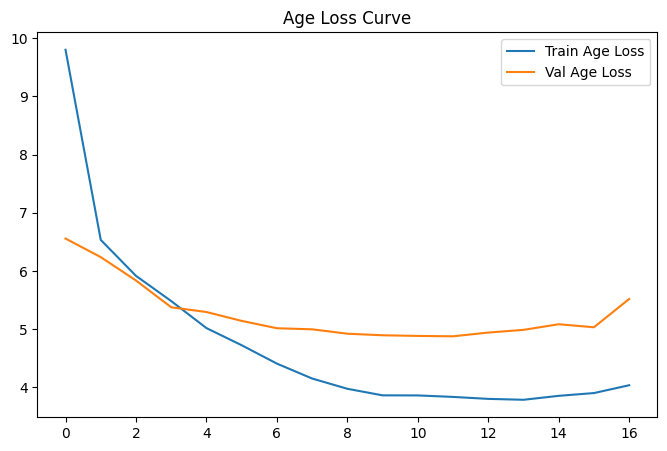

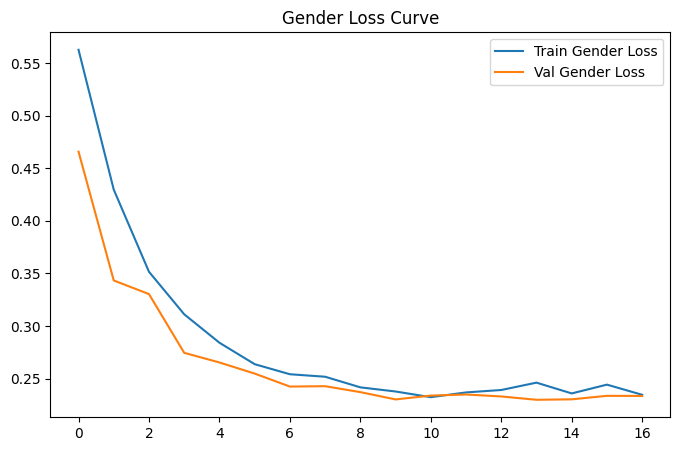

In [17]:
best_pair, best_trainer, loaders = hyperparameter_search()
_, _, test_loader = loaders

# 2. plot curves của model tốt nhất
plot_curves(best_trainer)

# 3. load best model
print("\nLoading best model...")
best_model = AgeGenderModel(pretrained=True)
best_model.load_state_dict(
    torch.load(f"{CHECKPOINT_DIR}/best_model.pth", map_location=DEVICE)
)
best_model = best_model.to(DEVICE)

# 4. evaluate on test set
evaluate_best_model(best_model, test_loader)

Saved: age_loss_curve.png, gender_loss_curve.png, total_loss_curve.png


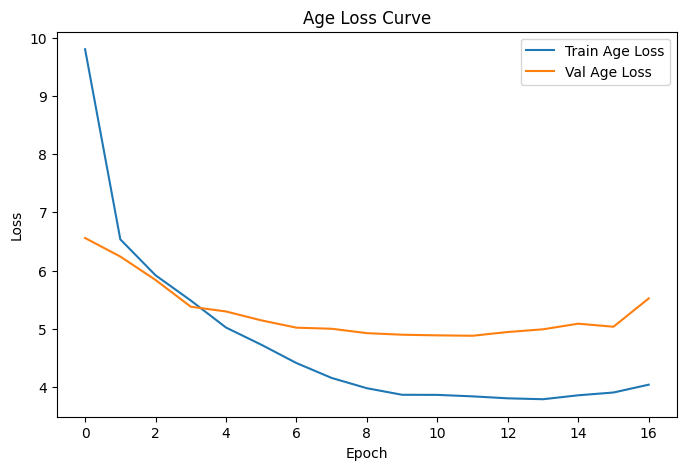

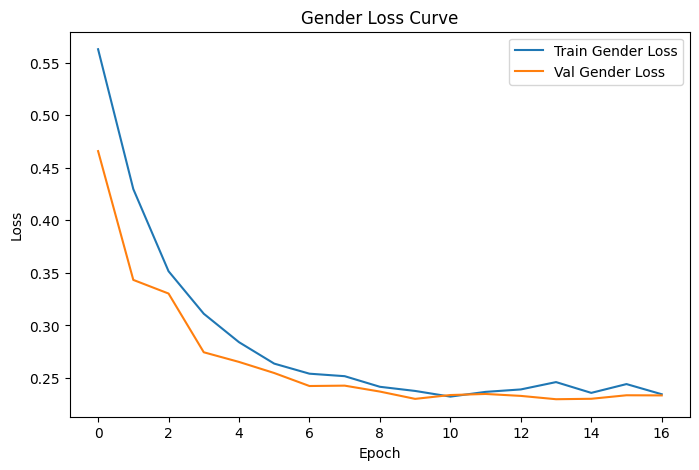

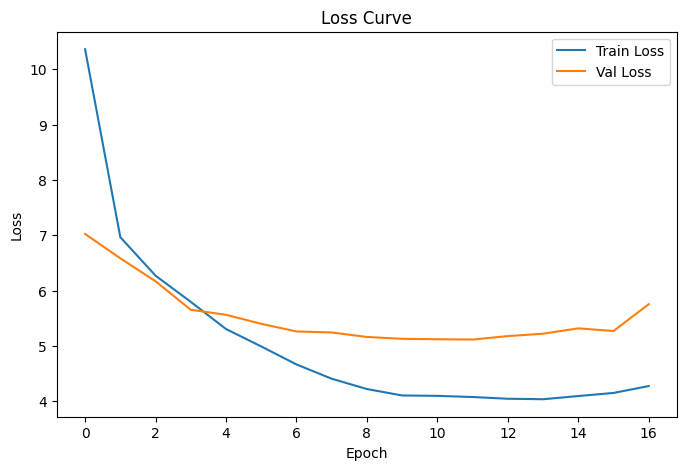

In [31]:
plot_curves(best_trainer)

In [32]:
best_model = AgeGenderModel(pretrained=True)
best_model.load_state_dict(
    torch.load(f"{CHECKPOINT_DIR}/best_model.pth", map_location=DEVICE)
)
best_model = best_model.to('cuda')

In [37]:
import torch
from PIL import Image
from torchvision import transforms

# ==== 1. Load image ====
img_path = "/content/labeled/test/img/20_1_2959.jpg"
img = Image.open(img_path).convert("RGB")

# ==== 2. Transform (phải giống lúc train) ====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

img_tensor = transform(img).unsqueeze(0)  # shape: (1,3,224,224)
img_tensor = img_tensor.to('cuda')

# ==== 3. Put into model ====
best_model.eval()

with torch.no_grad():
    age_pred, gender_pred = best_model(img_tensor)

# ==== 4. Post-process ====
age_pred = age_pred.item()        # scalar
gender_prob = torch.sigmoid(gender_pred).item()

gender = "Male" if gender_prob < 0.5 else "Female"

print("Predicted Age:", round(age_pred, 1))
print("Predicted Gender:", gender, f"(p={gender_prob:.3f})")


Predicted Age: 21.7
Predicted Gender: Female (p=0.983)
